# Обработка сигнала ЭКГ 

Электрокардиограмма широко используется для детекции ряда заболеваний.

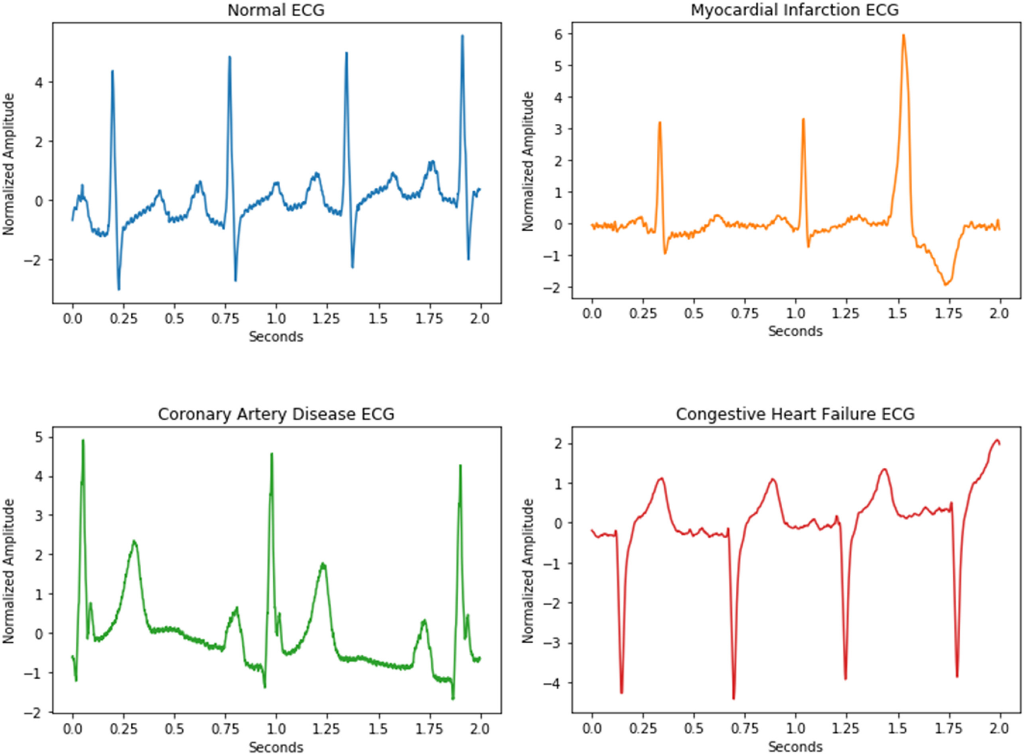

Допустим, вам прислали для сравнения две записи ЭКГ. Специалист, получивший эти записи, работал в MATLAB, где он создал инфраструктуру для манипуляции множества записей. Две из них в формате `struct` он сохранил в формате MATLAB и передал Вам.

In [1]:
%pylab inline
import pandas as pd
from ipywidgets import interact

Populating the interactive namespace from numpy and matplotlib


Функция для загрузки файлов в формате MATLAB есть в пакете `scipy`.

In [2]:
import scipy.io
import scipy.signal

In [4]:
u = r'ecg.mat'
o = scipy.io.loadmat(u)
o.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ecg1', 'ecg2'])

Поля, начинающиеся с двойных подчеркиваний, содержат метаданные файла.

In [4]:
o['__header__']

'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Nov 27 19:56:09 2013'

Кроме метаданных в файле две переменные: 'ecg1' и 'ecg2'

In [5]:
o['ecg1'].dtype

dtype([('data', 'O'), ('name', 'O'), ('name_col', 'O'), ('type', 'O'), ('units', 'O'), ('freq', 'O'), ('source', 'O'), ('date', 'O'), ('begin_time', 'O'), ('version', 'O'), ('data_quality', 'O'), ('history', 'O')])

In [6]:
o['ecg1'].dtype == o['ecg2'].dtype

True

По-умолчанию, переменная формата `struct` - структура, загружается в формате записи `numpy`: 1 структура - 1 запись.

In [7]:
o['ecg1'].shape

(1, 1)

In [8]:
o['ecg1'].dtype.fields

dict_proxy({'begin_time': (dtype('O'), 32),
            'data': (dtype('O'), 0),
            'data_quality': (dtype('O'), 40),
            'date': (dtype('O'), 28),
            'freq': (dtype('O'), 20),
            'history': (dtype('O'), 44),
            'name': (dtype('O'), 4),
            'name_col': (dtype('O'), 8),
            'source': (dtype('O'), 24),
            'type': (dtype('O'), 12),
            'units': (dtype('O'), 16),
            'version': (dtype('O'), 36)})

Преобразуем структуру в серию pandas.

In [8]:
d={k:o['ecg1'][0][0][k].squeeze() for k in o['ecg1'].dtype.fields}  #.squeeze() чтобы убрать лишние измерения
d=pd.Series(d)
d

data            [-6669.0, -6743.0, -6810.0, -6729.0, -6636.0, ...
name                                          Электрокардиограмма
name_col                                                      ecg
type                                                            1
units                                                          mV
freq                                                          250
source                                                         []
date                                                  22-Apr-2010
begin_time                                                      0
version                                                      5.16
data_quality                                                    4
history                                 Created by eegdata2oECG 1
dtype: object

Очевидно данные находятся в поле `data`.

(78000,)

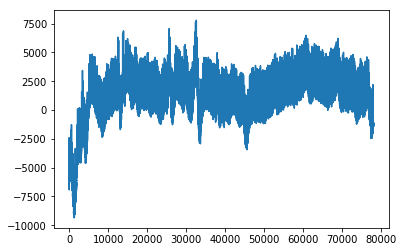

In [9]:
y = (d['data'])
plot(y)
y.shape

Посмотрим фрагмент подробнее.

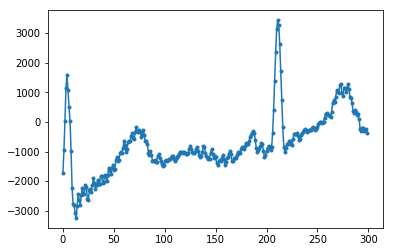

In [31]:
plot(y[3200:3500], '.-');

Да это же кардиограмма! Мы знаем, что сердце бъется примерно один раз в секунду, однако числа по оси Ox не похожи ни на секунды, ни на миллисекунды.

В поле `freq` мы обнаруживаем частоту сигнала.

In [21]:
freq=float(d['freq'])
freq

250.0

$$T = \frac{1}{freq}$$

Для второй записи извлечем данные напрямую, поскольку мы уже изучили структуру данных.

In [23]:
y2=o['ecg2'][0][0]['data']
y2.shape

(150800, 1)

Наложим два сигнала, задавая попарно координаты x и y через запятую.

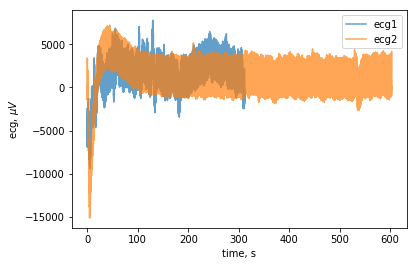

In [34]:
x=arange(0, len(y)/freq, 1/freq)
x2=arange(0, len(y2)/freq, 1/freq)
plot(x,y, x2,y2, alpha=.7)
xlabel('time, s'); ylabel('ecg, $\mu V$'); legend(['ecg1','ecg2']);

Видно, что первая запись продолжалась около 5 мин, а вторая запись длинее - около 10 мин. При этом в начале записи сильно отклоняются от нуля.

Чтобы убрать колебания изолинии - профильтруем сигнал фильтром низких частот.

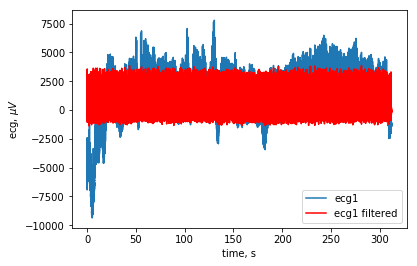

In [40]:
# делаем фильтр с пропусканием выше 2 Гц
b, a = scipy.signal.firwin(int(freq/2), 2/(freq/2), pass_zero=False), 1

# запускаем фильтр без сдвига фазы
yf = scipy.signal.filtfilt(b, a, y)

# смотрим эффект на картинке
plot(x,y, x,yf,'r');
xlabel('time, s'); ylabel('ecg, $\mu V$'); legend(['ecg1','ecg1 filtered']);

Посмотрим поближе на фрагмент записи, чтобы определить надежный порог для поиска R-зубцов.

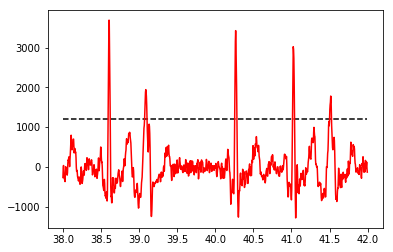

In [48]:
t0 = 38 # начальная точка просмотра, попробуйте поменять
dlit = 4
porog = 1200


i0 = int(t0*freq)
ii = slice(i0, i0+int(dlit*freq))
plot(x[ii], yf[ii], 'r');

hlines(porog, x[ii][0], x[ii][-1], 'k','--');

Следующий шаг после подбора порогового значения (показан пунктиром на пред. рисунке) - выделить участки выше порога и найти их пиковые значения.

Конечно же существуют специальные пакеты для подсчета пульса по записи ЭКГ с учетом инверсии сигнала, помех и т.д.

Данный алгоритм служит для демонстрации принципов анализа сигналов.

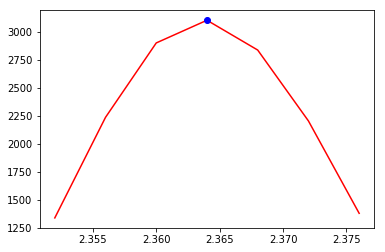

In [17]:
# находим участки сигнала выше порога

#вначале один
i=500
iStart = i + argmax(yf[i:] > porog)   # начало зубца - превышение порога
iEnd = iStart + argmin(yf[iStart:] > porog)  # конец зубца
ii=slice(iStart,iEnd)
plot(x[ii],yf[ii],'r');

iR= iStart + argmax(yf[ii])
plot(x[iR], yf[iR], 'bo');

In [18]:
# теперь повторим это для всех участков
# введем мертвую зону 400 мс, чтобы не попадать на высокие Т-зубцы
nDead=int(0.4*freq)

rr=[]

i=0
while i< len(yf):  # двигаемся вдоль графика
    iStart = i + argmax(yf[i:] > porog)  # начало зубца - превышение порога
    if iStart == i:
        break
    iEnd = iStart + argmin(yf[iStart:] > porog) # конец зубца
    ii=slice(iStart,iEnd)
    iR= iStart + argmax(yf[ii])

    _r=[x[iR], yf[iR]]
    rr.append(_r)
    
    i=iEnd+nDead  #прыгаем через "мертвую зону"

rr.__len__()

376

Можно оптимизировать алгоритм, уменьшив фрагмент ЭКГ для поиска следующего максимума, ведь мы знаем что сердце не может не биться более 2 секунд. Для этого надо задать конечный индекс по формуле `i + int(2*freq)`, однако надо еще сделать проверку - не находимся ли мы близко к концу массива. Оптимизировать и сравнить прирост производительности можете сами.

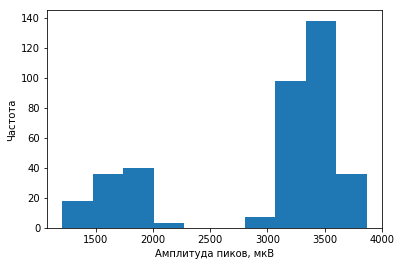

In [19]:
rr = array(rr)
hist(rr[:,1]); xlabel('Амплитуда пиков, мкВ'); ylabel('Частота');

Выделяются два вида зубцов - высокие и низкие (примерно в половину от амплитуды высоких).

Посмотрим как варьируют интервалы между найденными зубцами.

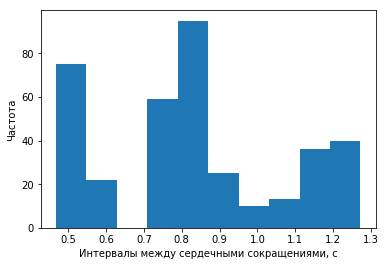

In [20]:
drr=diff(rr[:,0])
hist(drr); xlabel('Интервалы между сердечными сокращениями, с'); ylabel('Частота');

Нарушения ритма могут иметь разные причины. Один из подходов - сопоставить аномальный сердечный цикл с соседними, например, с предыдущим. Для наглядности отложим по горизонтальной оси длительность интервала, а по вертикальной - длительность предыдущего по отношению к нему.

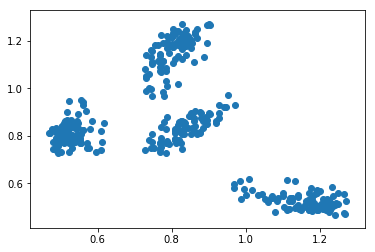

In [21]:
scatter(drr[1:], drr[:-1]);

Мы видим четкие четыре обособленных группы значений! У этого человека серьезные проблемы с сердечной регуляцией.
Подробности см. [Экстрасистолия](http://medicinapediya.ru/kardiologiya_730/ekstrasistoliya16217.html)

### +++:

Для удобства загрузки данных из `mat`-файлов в виде вложенных структур можно написать несложную обертку.

In [22]:
def loadmat(filename, **kwa):
    ''' Загружает структуру из mat-файла
    
    для загрузки определенных переменных:
    
        variable_names = ['a']  
        по-умолчанию None
        
    '''
    #http://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
    
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True, **kwa)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

проверка

In [23]:
u=r'ecg.mat'
loadmat(u)

{'__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Nov 27 19:56:09 2013',
 '__version__': '1.0',
 'ecg1': {'begin_time': 0,
  'data': array([-6669., -6743., -6810., ..., -1430., -1328., -1217.], dtype=float32),
  'data_quality': 4,
  'date': u'22-Apr-2010',
  'freq': 250,
  'history': u'Created by eegdata2oECG 1',
  'name': u'\u042d\u043b\u0435\u043a\u0442\u0440\u043e\u043a\u0430\u0440\u0434\u0438\u043e\u0433\u0440\u0430\u043c\u043c\u0430',
  'name_col': u'ecg',
  'source': array([], dtype=float64),
  'type': 1,
  'units': u'mV',
  'version': u'5.16'},
 'ecg2': {'begin_time': 0,
  'data': array([  5.,  -3., -33., ..., -43.,  27.,  69.], dtype=float32),
  'data_quality': 4,
  'date': u'25-Jun-2010',
  'freq': 250,
  'history': u'Created by eegdata2oECG 1',
  'name': u'\u042d\u043b\u0435\u043a\u0442\u0440\u043e\u043a\u0430\u0440\u0434\u0438\u043e\u0433\u0440\u0430\u043c\u043c\u0430',
  'name_col': u'ecg',
  'source': array([], dtype=float64),
  't